30

In [ ]:
import sqlalchemy

In [ ]:
import numpy as np
import torch 
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch import nn
import torch.nn.functional as F

# import torcheval
from torcheval.metrics import MeanSquaredError, Mean

In [ ]:
import fastcore.all as fc
from fastprogress import progress_bar,master_bar

In [ ]:
from fastai.vision.all import *

In [ ]:
def_device = 'cuda'
# def_device = 'cpu'

## Loading Data

In [ ]:
load_from = '../nbs_artifacts/99.99_apsimx_agg/'
met_np = np.load(load_from+'met_np.npy')
met_np_lonlatyear = np.load(load_from+'met_np_lonlatyear.npy')

In [ ]:
soils_i = np.load(load_from+'soils_np_i.npy')
soils_i.shape

(340, 200, 24)

In [ ]:
cult_i = np.load(load_from+'SimCult.np.npy')
cult_i.shape

(3325, 10)

In [ ]:
engine=sqlalchemy.create_engine(f'sqlite:///'+load_from+'res.db')
results = pd.read_sql('select * from Results', engine)
engine.dispose()
results.shape

(2505501, 9)

In [ ]:
# to start look only at one location
mask = (results.Soils_Idx == 309
   ) & (results.Met_Idx == 63993.0)

ys = np.array(results.loc[mask, 'yield_Kgha'])
xs = cult_i[list(results.loc[mask, 'Cult_Idx']), ]


ys = torch.from_numpy(ys[:, None]).to(torch.float)
xs = torch.from_numpy(xs).to(torch.float)

## Packing Data

In [ ]:
bs=100

In [ ]:
class simpleDS(Dataset):
    def __init__(self,  x, y):
        self.y = y
        self.x = x
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx, ], self.y[idx]

train_dl = DataLoader(
    simpleDS(
        xs[0:1000, ], ys[0:1000]
    ), #.to(device),
    batch_size = 1000, shuffle = True)

valid_dl = DataLoader(
    simpleDS(
        xs[1000:, ], ys[1000:]
    ), #.to(device),
    batch_size = 1000, shuffle = True)

In [ ]:
[e.shape for e in next(iter(train_dl))]

[torch.Size([1000, 10]), torch.Size([1000, 1])]

In [ ]:
# dls = DataLoaders(train_dl, valid_dl, device='cpu')
dls = DataLoaders(train_dl, valid_dl, device=def_device)

## Basic Learner

In [ ]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)
                
model =  nn.Sequential(nn.Linear(10, 10), nn.ReLU(), nn.Linear(10, 1))
learn = Learner(model, dls, F.mse_loss, lr=0.2)
learn.fit(1)

0 True 4676448.256 0.0
0 False 2.712551173721024e+26 0.0


## Basic Learner + Callbacks

In [ ]:
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

class Callback(): order = 0

def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)
            
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

In [ ]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


In [ ]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
        
def get_model(): return nn.Sequential(nn.Linear(10, 10), nn.ReLU(), nn.Linear(10, 1))        

model =  get_model()
model = model.to(def_device)
learn = Learner(model, dls, F.mse_loss, lr=0.2, cbs = [CompletionCB()])
learn.fit(1)

Completed 9 batches


In [ ]:
# uses exception to exit fitting after only one batch
#     
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

In [ ]:
learn = Learner(model, dls, F.mse_loss, lr=0.2, cbs = [SingleBatchCB(), CompletionCB()])
learn.fit(1)

## Adding in metrics

In [ ]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

In [ ]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

In [ ]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.4500)

In [ ]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.6176), 0.62)

## Adding more Callbacks

In [ ]:
def to_cpu(x):
    # not sure what Mapping is-- not a keyword as far as i can tell
#     if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, dict): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [ ]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [ ]:
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

In [ ]:
model =  get_model()
model = model.to(def_device)
metrics = MetricsCB(accuracy = MeanSquaredError())
learn = Learner(model, dls, F.mse_loss, lr=0.2, cbs = [DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '4553344.000', 'loss': '4553344.000', 'epoch': 0, 'train': 'train'}
{'accuracy': '1521121615371094009460031488.000', 'loss': '1521121873214931684227547136.000', 'epoch': 0, 'train': 'eval'}


## Now the Flexible Case

In [ ]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, 
                 opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
                
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [ ]:
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp # NB: I added self.n_inp after the lesson. This allows us to train models with more than one input or output.
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [ ]:
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

In [ ]:
model =  get_model()
model = model.to(def_device)

accuracy,loss,epoch,train
4502922.000,4502922.752,0,train
3775510457257203255593664512.000,3775510631030029190602686464.000,0,eval
3565992338068010168339136512.000,3565992366402209311847612416.000,1,train
558819946478294306694103040.000,558819948922219071365185536.000,1,eval


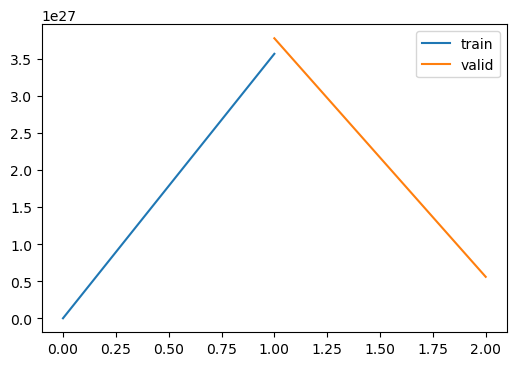

In [ ]:
metrics = MetricsCB(accuracy = MeanSquaredError())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.mse_loss, lr=0.2, cbs = cbs)
learn.fit(2)

## Updates

In [ ]:
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [ ]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

accuracy,loss,epoch,train
4450081.000,4450079.744,0,train
3686058505894970897897357312.000,3686058689208879351676796928.000,0,eval
3481466405243221209306365952.000,3481466690946393524074971136.000,1,train
545568912340385787386265600.000,545568838416549706825990144.000,1,eval


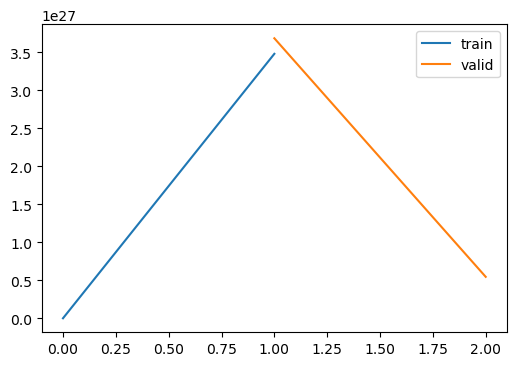

In [ ]:
model =  get_model()
model = model.to(def_device)

metrics = MetricsCB(accuracy = MeanSquaredError())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.mse_loss, lr=0.2, cbs = cbs)
learn.fit(2)

## TrainLearner + MomentumLearner

In [ ]:
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [ ]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
4540462.000,4540462.592,0,train
1980138588985075317759541248.000,1980138848393024907887247360.000,0,eval
1870122354903424141598130176.000,1870122560326366282767138816.000,1,train
293065046412502132963934208.000,293065001209669813150941184.000,1,eval


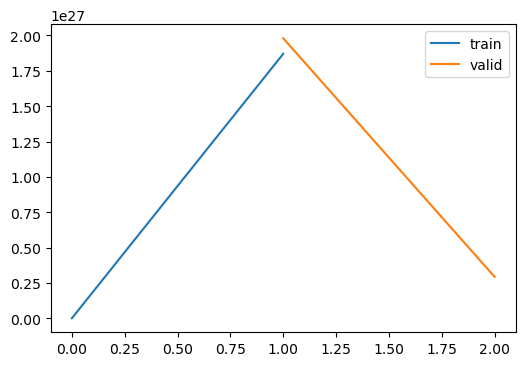

In [ ]:
model =  get_model()
model = model.to(def_device)

metrics = MetricsCB(accuracy = MeanSquaredError())
cbs = [#TrainCB(), # <- # NB: No TrainCB
    DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(model, dls, F.mse_loss, lr=0.2, cbs = cbs)
learn.fit(2)

## LRFinderCB

In [ ]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult

In [ ]:
lrfind = LRFinderCB()

cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(model, dls, F.mse_loss, lr=0.2, cbs = cbs)
learn.fit(1)

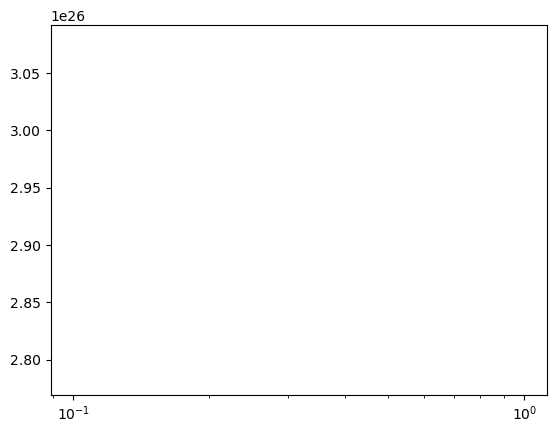

In [ ]:
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

## Adding Schedulers

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

In [ ]:
# Updated version

class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [ ]:
model =get_model().to(def_device)

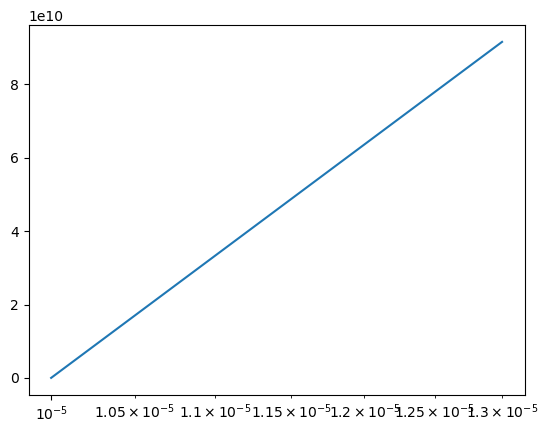

In [ ]:
# I don't have a clue as to why but this produces a linear response the first time it's run
# the second time it behaves normally.

cbs = [DeviceCB()]
learn = MomentumLearner(model, dls, F.mse_loss, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

In [ ]:
# lr_find was added in lesson 18. It's just a shorter way of using LRFinderCB.
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

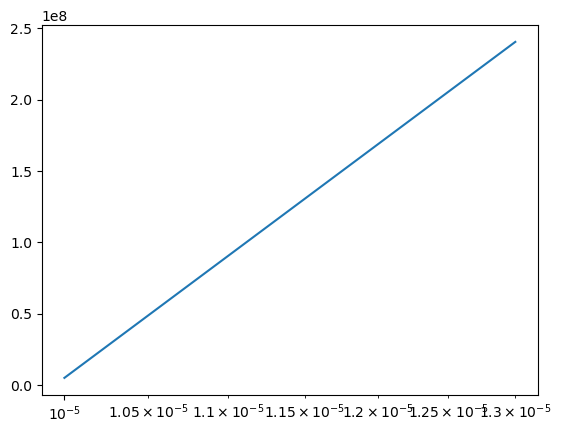

In [ ]:
model = get_model()
MomentumLearner(model, dls, F.mse_loss, cbs=cbs).lr_find()

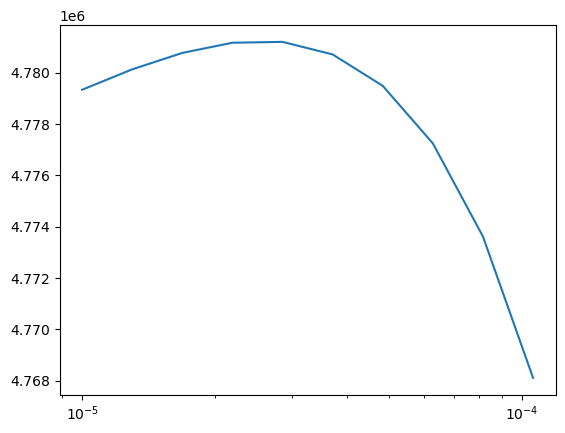

In [ ]:
MomentumLearner(model, dls, F.mse_loss, cbs=cbs).lr_find()

# Activations

In [ ]:
def lin_layers(): return [nn.Linear(10, 10), nn.ReLU(), nn.Linear(10, 1)]

In [ ]:
def fit(model, epochs = 1, xtra_cbs = None):
    # fc.L is a Fastcore list. List that you can index with masks or a list of indices
    learn = Learner(model, dls, F.mse_loss, lr=0.2, cbs = cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
4773116.000,4773115.904,0,train
552855191782060323179069440.000,552855232175248695674011648.000,0,eval
521938854542892736280788992.000,521938837719462132261584896.000,1,train
81791083112025038893613056.000,81791093430275361524940800.000,1,eval
81791083112025038893613056.000,81791094696580309074313216.000,2,train
29444775900803517982441472.000,29444783687147796165558272.000,2,eval
29444775900803517982441472.000,29444783796009982870159360.000,3,train
10600117110679977628532736.000,10600121270239914849468416.000,3,eval


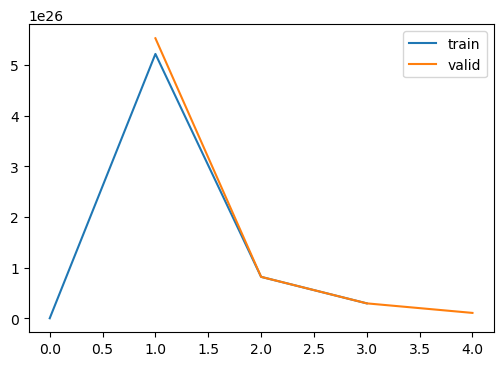

In [ ]:
metrics = MetricsCB(accuracy=MeanSquaredError())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

# model = get_model()

learn = fit(nn.Sequential(*lin_layers()), 4)

In [ ]:
# aside: what do the parameters look like?

In [ ]:
# for name, param in model.named_parameters():
#     print(name, param)

In [ ]:
weight_bias_list=[(name, param) for name, param in model.named_parameters()]
import plotly.express as px
px.imshow(torch.Tensor.numpy(weight_bias_list[0][1].detach().cpu()))

In [ ]:
import plotly.express as px
px.imshow(torch.Tensor.numpy(weight_bias_list[0][1].detach().cpu()))

In [ ]:
np.std(torch.Tensor.numpy(weight_bias_list[0][1].detach().cpu()))

1385.7711

In [ ]:
px.imshow(np.std(torch.Tensor.numpy(weight_bias_list[0][1].detach().cpu()), axis=0)[None,:])

## Hooks

### Hooks, Manual

In [ ]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):                              # This is the big difference
        for i,l in enumerate(self.layers):              # same sort of idea as in forward
            x = l(x)                                    # but activation mean and std 
            self.act_means[i].append(to_cpu(x).mean())  # is tracked
            self.act_stds [i].append(to_cpu(x).std ())  #
        return x                                        #
    
    def __iter__(self): return iter(self.layers)

accuracy,loss,epoch,train
4494161.500,4494161.408,0,train
4444774270238265473274740736.000,4444774979875809531380367360.000,0,eval


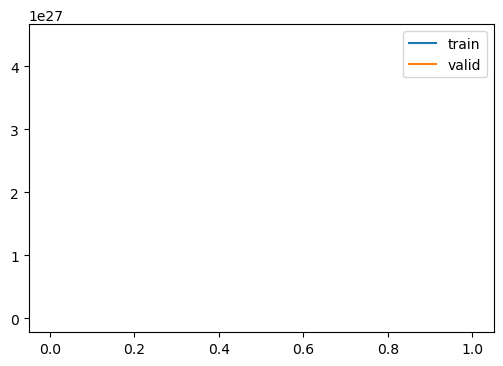

In [ ]:
model = SequentialModel(*lin_layers())
learn = fit(model, 1)

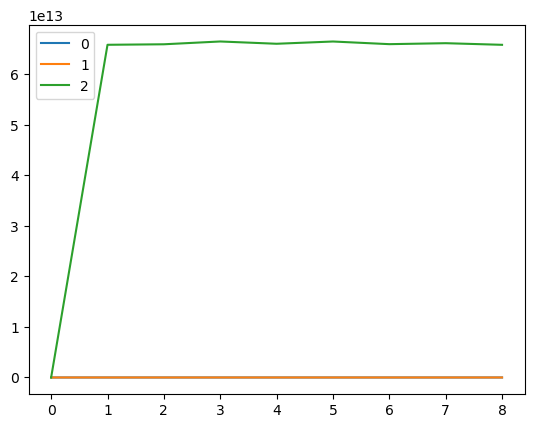

In [ ]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

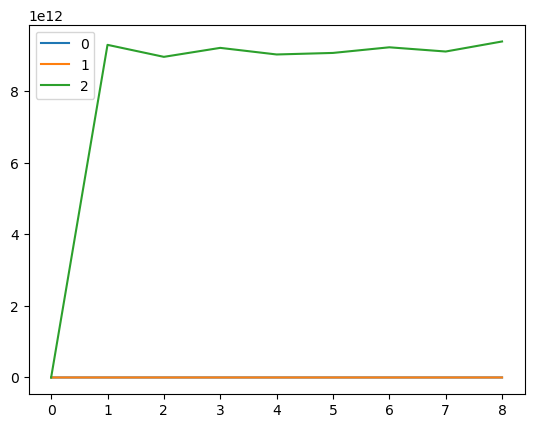

In [ ]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

### Hooks, Pytorch

In [ ]:
# A hook attaches to a layer and needs
# 1. module
# 2. input
# 3. output
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds [i].append(to_cpu(outp).std())

In [ ]:
model = SequentialModel(*lin_layers())

act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [ ]:
# for each layer, register a hook.
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
4799935.500,4799934.976,0,train
182426806567429544431583232.000,182426826597836877467746304.000,0,eval


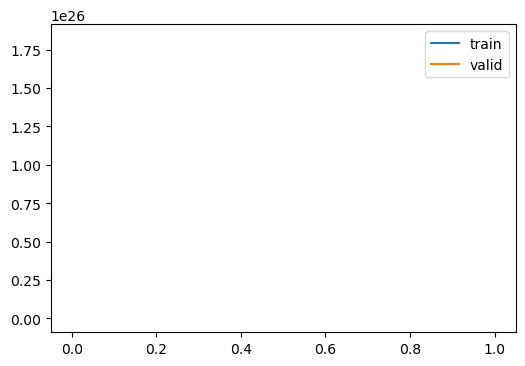

<__main__.Learner>

In [ ]:
fit(model, 1)

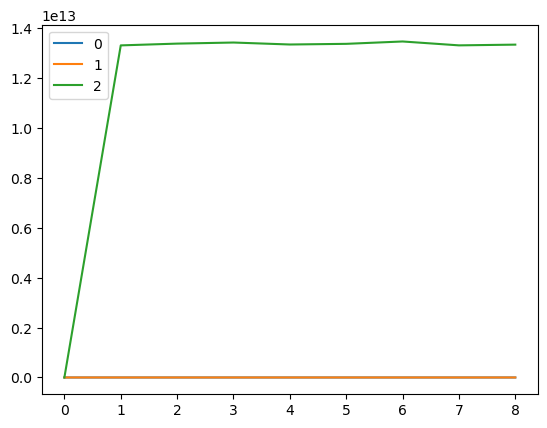

In [ ]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook, class

In [ ]:
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove() # Important to remove hooks when deleted to free up memory when the model is deleted.

In [ ]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [ ]:
model = nn.Sequential(*lin_layers())

In [ ]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
5560669.500,5560670.208,0,train
9262772552813962499981312.000,9262772952701151054135296.000,0,eval


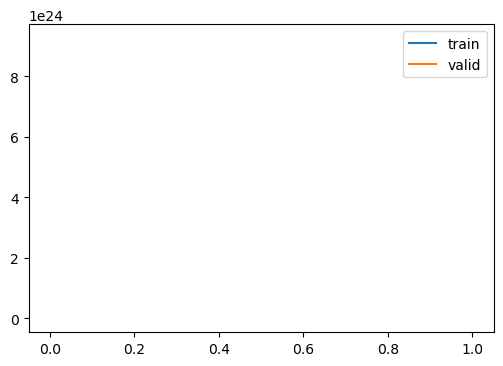

In [ ]:
learn = fit(model)

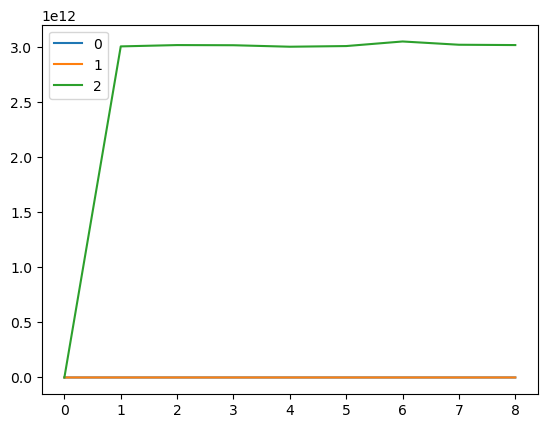

In [ ]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

### Hook_s_, class

In [ ]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("let's go!")
        return self
    def __exit__ (self, *args): print("all done!")
    def hello(self): print("hello.")

with DummyCtxMgr() as dcm: dcm.hello()

let's go!
hello.
all done!


In [ ]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Say bye to item {i}")
        super().__delitem__(i)
        
dml = DummyList([1,3,2])
print(dml)
del(dml[2])
dml

[1, 3, 2]
Say bye to item 2


[1, 3]

In [ ]:
# updated version, previous wasn't based on list.
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [ ]:
model = nn.Sequential(*lin_layers())

accuracy,loss,epoch,train
5480589.500,5480589.312,0,train
1321421414850701889110016.000,1321421455404578472198144.000,0,eval


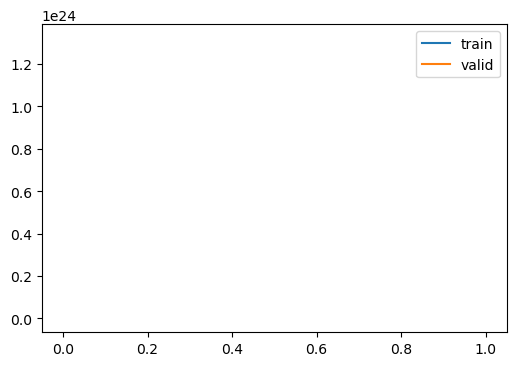

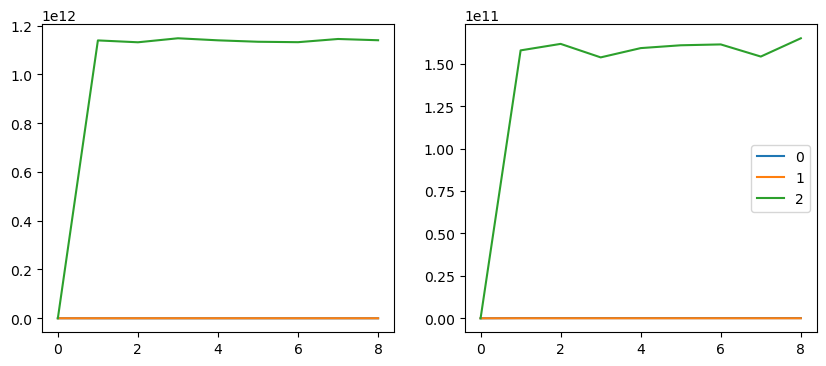

In [ ]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

### HooksCallback (allows filtering)

In [ ]:
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [ ]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Linear))

accuracy,loss,epoch,train
4662177.500,4662177.280,0,train
1449155406503307230578737152.000,1449155420502108130882093056.000,0,eval


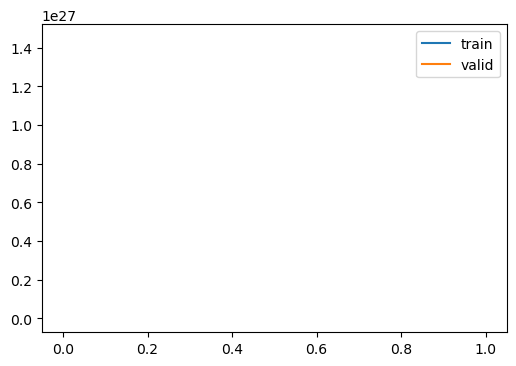

In [ ]:
model = nn.Sequential(*lin_layers())
fit(model, xtra_cbs=[hc]);

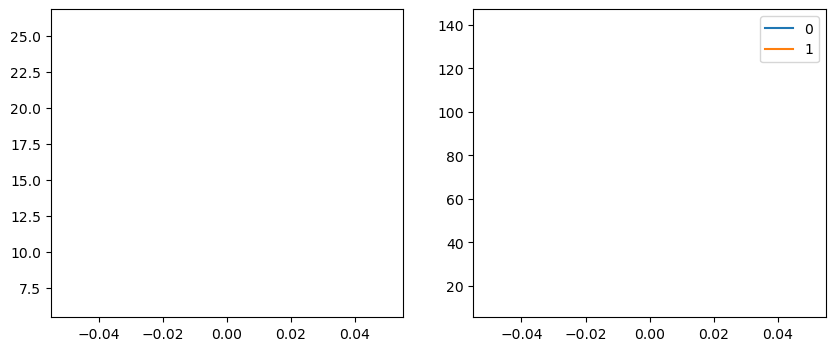

In [ ]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

### Histograms

In [ ]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

accuracy,loss,epoch,train
5369476.000,5369476.608,0,train
414182655016773462523904.000,414182662463106708406272.000,0,eval


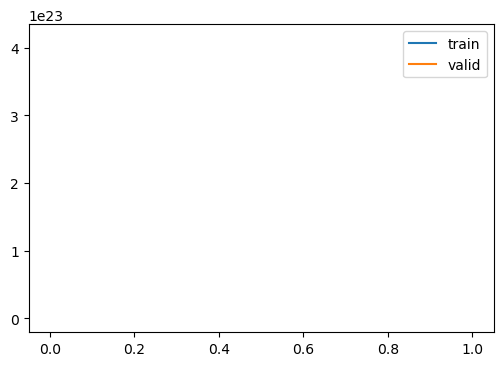

In [ ]:
model = nn.Sequential(*lin_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Linear))
fit(model, xtra_cbs=[hc]);

In [ ]:
model[0].parameters

<bound method Module.parameters of Linear(in_features=10, out_features=10, bias=True)>

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

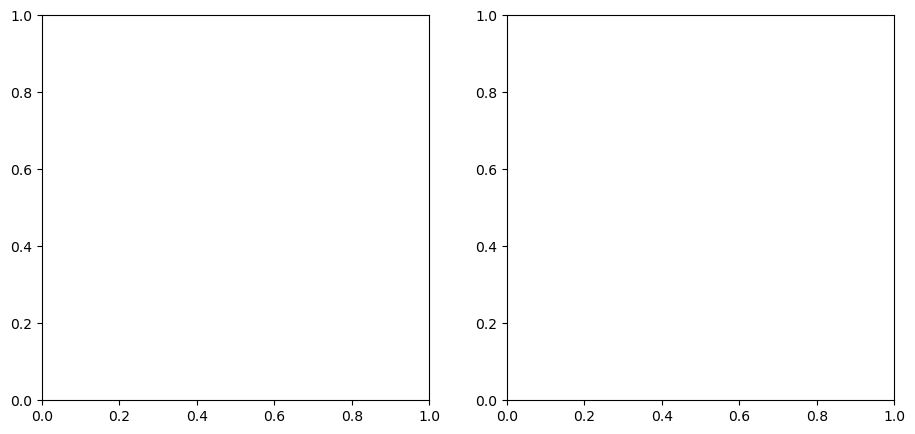

In [ ]:
fig, axes = get_grid(len(hc), figsize=(11,5))

In [ ]:
h, _ = hc

[len(e) for e in h.stats]

[1, 1, 1]

In [ ]:
h_concat = [
    torch.concat([e.reshape(1) for e in h.stats[0]]),
    torch.concat([e.reshape(1) for e in h.stats[1]]),
    torch.concat([e[:, None] for e in h.stats[2]], axis = 1)
]
[e.shape for e in h_concat]

[torch.Size([1]), torch.Size([1]), torch.Size([40, 1])]

<matplotlib.image.AxesImage>

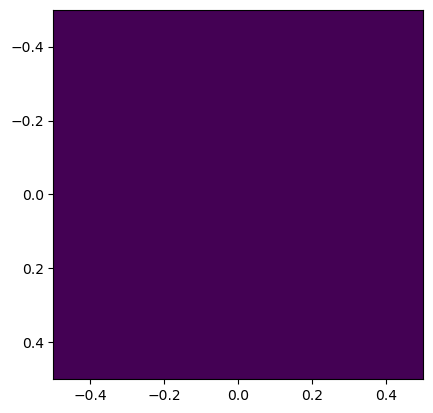

In [ ]:
plt.imshow(torch.Tensor.numpy(h_concat[0])[:, None])

<matplotlib.image.AxesImage>

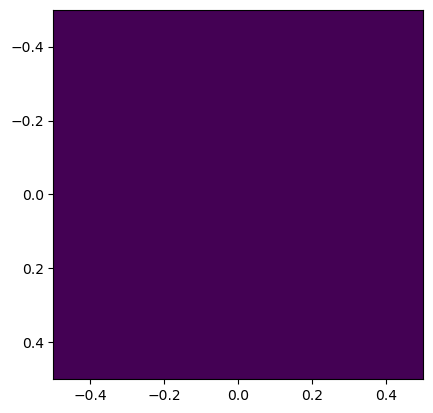

In [ ]:
plt.imshow(torch.Tensor.numpy(h_concat[1])[:, None])

<matplotlib.image.AxesImage>

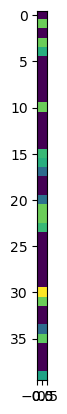

In [ ]:
plt.imshow(torch.Tensor.numpy(h_concat[2]))

## Initalizations


In [ ]:
# Make up some data
a0=3
a1=3

n_obs=1000
x_important = torch.randn(n_obs)
xs=torch.concat([x_important[:,None], torch.randn(n_obs,9)],axis=1)
ys=a0+a1*x_important
ys=ys[:, None]

In [ ]:
px.scatter(x=x_important, y=ys[:, 0])

In [ ]:
train_dl = DataLoader(
    simpleDS(
        xs, ys
    ),
    batch_size = 10, shuffle = True)

valid_dl = DataLoader(
    simpleDS(
        xs, ys
    ), 
    batch_size = 10, shuffle = True)

dls = DataLoaders(train_dl, valid_dl, device=def_device)

In [ ]:
model=nn.Sequential(*[nn.Linear(10,1)])


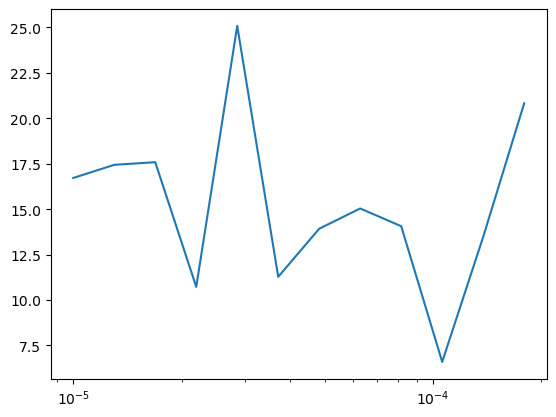

In [ ]:
cbs = [DeviceCB()]
learn = MomentumLearner(model, dls, F.mse_loss, lr=1e-5, cbs=cbs)
learn.fit(1, cbs=LRFinderCB())

accuracy,loss,epoch,train
2.649,2.649,0,train
0.021,0.021,0,eval
0.003,0.003,1,train
0.000,0.000,1,eval
0.000,0.000,2,train
0.000,0.000,2,eval
0.000,0.000,3,train
0.000,0.000,3,eval
0.000,0.000,4,train
0.000,0.000,4,eval


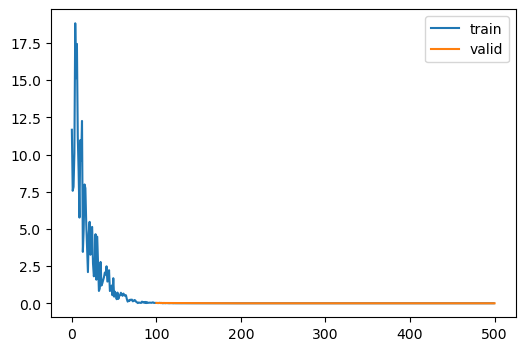

In [ ]:
learn = MomentumLearner(model, dls, F.mse_loss, lr=0.002, cbs=[DeviceCB(), metrics, ProgressCB(plot=True)])
learn.fit(5)

In [ ]:
weight_bias_list=[(name, param) for name, param in model.named_parameters()]
weight_bias_list

[('0.weight',
  Parameter containing:
  tensor([[ 3.0000e+00, -5.1282e-07, -5.3096e-07,  4.3568e-07, -3.9637e-07,
            1.1458e-07,  3.9075e-07, -1.4743e-07,  2.6395e-07,  9.3511e-08]],
         device='cuda:0', requires_grad=True)),
 ('0.bias',
  Parameter containing:
  tensor([3.0000], device='cuda:0', requires_grad=True))]

In [ ]:
layer0w=torch.Tensor.numpy(weight_bias_list[0][1].detach().cpu())
layer0b=torch.Tensor.numpy(weight_bias_list[1][1].detach().cpu())
px.imshow(layer0w)

In [ ]:
layer0w

array([[ 2.99999642e+00, -5.12821600e-07, -5.30959483e-07,
         4.35683035e-07, -3.96367028e-07,  1.14581916e-07,
         3.90747402e-07, -1.47426974e-07,  2.63953069e-07,
         9.35113391e-08]], dtype=float32)

In [ ]:
from captum.attr import IntegratedGradients

In [ ]:
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(xs.to('cuda'), torch.zeros(xs.shape).to('cuda'), target=0, return_convergence_delta=True)

In [ ]:
attr = torch.Tensor.numpy(attributions.detach().cpu())
px.imshow(attr[0:10, ])

In [ ]:
px.imshow(np.abs(attr[0:10, ]))

In [ ]:
# harder version with nonlinear response

a0 =  10
a1s = torch.randn(2, 1)
a2s = torch.randn(2, 1)

xs = torch.randn(n_obs, 2)
ys = a0 + ((xs@a1s)**1+(xs@a1s)**2)

In [ ]:
x1x2y = torch.concat([xs, ys], axis = 1)

px.scatter_3d(x = x1x2y[:, 0], y = x1x2y[:, 1], z = x1x2y[:, 2], color = x1x2y[:, 2])

In [ ]:
train_dl = DataLoader(
    simpleDS(
        xs, ys
    ),
    batch_size = 10, shuffle = True)

valid_dl = DataLoader(
    simpleDS(
        xs, ys
    ), 
    batch_size = 10, shuffle = True)

dls = DataLoaders(train_dl, valid_dl, device='cpu')

accuracy,loss,epoch,train
27.678,27.678,0,train
1.645,1.645,0,eval
1.440,1.440,1,train
1.381,1.381,1,eval


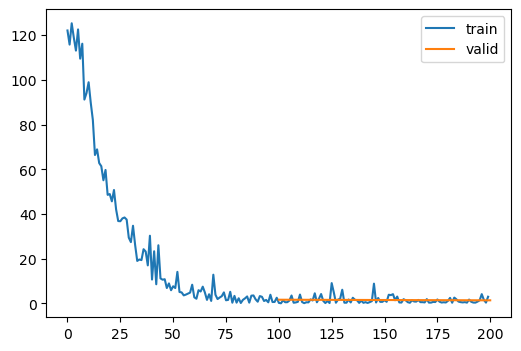

In [ ]:
# underpowered linear model
model=nn.Sequential(*[nn.Linear(2,1)])
learn = MomentumLearner(model, dls, F.mse_loss, lr=0.002, cbs=[DeviceCB(), metrics, ProgressCB(plot=True)])
learn.fit(2)

In [ ]:
with torch.no_grad():
    yhats = (learn.model(torch.Tensor(x1x2y[:, 0:2]).to(def_device))).detach().cpu()


In [ ]:
px.scatter_3d(x = x1x2y[:, 0], y = x1x2y[:, 1], z = yhats[:, 0], color = yhats[:, 0])

accuracy,loss,epoch,train
11.185,11.185,0,train
0.083,0.083,0,eval
0.055,0.055,1,train
0.039,0.039,1,eval
0.035,0.035,2,train
0.028,0.028,2,eval
0.025,0.025,3,train
0.020,0.020,3,eval
0.020,0.020,4,train
0.017,0.017,4,eval


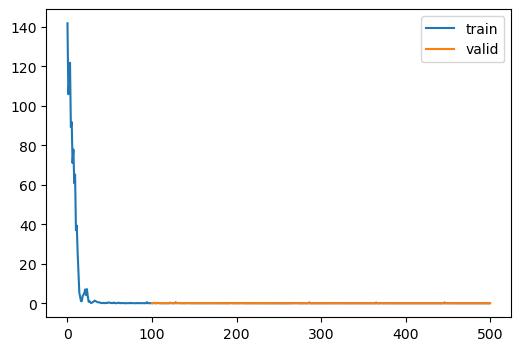

In [ ]:
# Higher capacity  model
model=nn.Sequential(*[nn.Linear(2,10), nn.ReLU(), nn.Linear(10, 1)])
learn = MomentumLearner(model, dls, F.mse_loss, lr=0.002, cbs=[DeviceCB(), metrics, ProgressCB(plot=True)])
learn.fit(5)

In [ ]:
with torch.no_grad():
    yhats = (learn.model(torch.Tensor(x1x2y[:, 0:2]).to(def_device))).detach().cpu()


In [ ]:
px.scatter_3d(x = x1x2y[:, 0], y = x1x2y[:, 1], z = yhats[:, 0], color = yhats[:, 0])

accuracy,loss,epoch,train
15.125,15.125,0,train
0.331,0.331,0,eval
0.291,0.291,1,train
0.222,0.222,1,eval


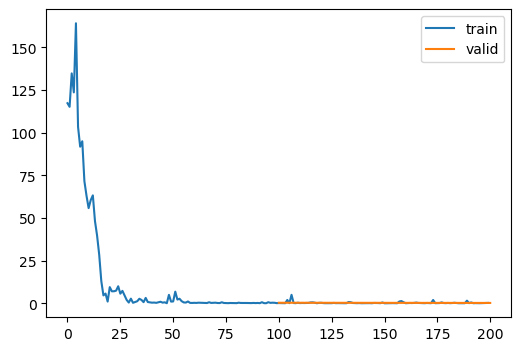

In [ ]:
model=nn.Sequential(*[nn.Linear(2,10), nn.ReLU(), nn.Linear(10, 1)])
learn = MomentumLearner(model, dls, F.mse_loss, lr=0.002, cbs=[DeviceCB(), metrics, ProgressCB(plot=True)])
learn.fit(2)

In [ ]:
model.apply(lambda m: print(type(m).__name__));

Linear
ReLU
Linear
Sequential


In [ ]:
from torch.nn import init
def init_weights(m):
    if isinstance(m, (nn.Linear,nn.Linear)): init.kaiming_normal_(m.weight)

accuracy,loss,epoch,train
8.840,8.840,0,train
0.203,0.203,0,eval
0.167,0.167,1,train
0.161,0.161,1,eval


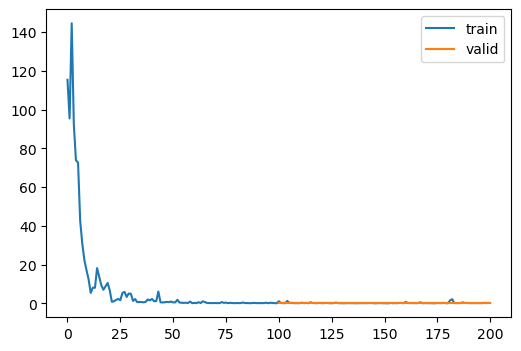

In [ ]:
model=nn.Sequential(*[nn.Linear(2,10), nn.ReLU(), nn.Linear(10, 1)])
model.apply(init_weights);
learn = MomentumLearner(model, dls, F.mse_loss, lr=0.002, cbs=[DeviceCB(), metrics, ProgressCB(plot=True)])
learn.fit(2)

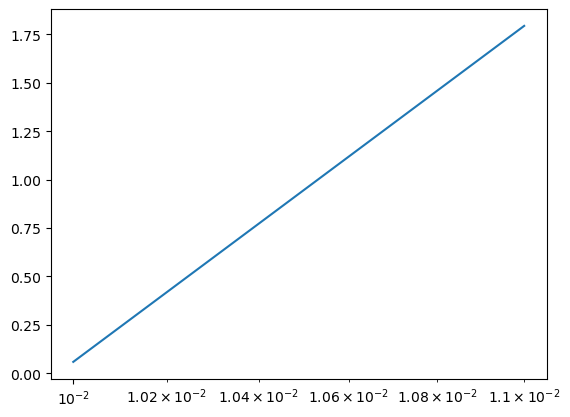

In [ ]:
MomentumLearner(model, dls, F.mse_loss, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

## Init with LSUV

In [ ]:
def _lsuv_stats(hook, mod, inp, outp):
#     acts = to_cpu(outp)
    acts = outp
    hook.mean = acts.mean()
    hook.std = acts.std()
    # added safety to not fully normalize instead of crashing
    # in test case the linear weight matrix is becoming inf/-inf
    if (torch.isnan(hook.std) or
        hook.std == 0):
        hook.std = 1
    
#     print(acts.std())

def lsuv_init(model, m, m_in, xb):
    print(m)
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()

In [ ]:
model=nn.Sequential(*[nn.Linear(2,10), nn.ReLU(), nn.Linear(10, 1)])
relus = [o for o in model.modules() if isinstance(o, nn.ReLU)]
lins = [o for o in model.modules() if isinstance(o, nn.Linear)]

In [ ]:
# weight_bias_list=[(name, param) for name, param in model.named_parameters()]; weight_bias_list

In [ ]:
model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
xb,yb = next(iter(dls.train))
xb
for ms in zip(relus,lins): lsuv_init(model, *ms, xb) #.to(def_device))

ReLU()


In [ ]:
weight_bias_list=[(name, param) for name, param in model.named_parameters()]; weight_bias_list

[('0.weight',
  Parameter containing:
  tensor([[ 1.1667, -0.1128],
          [ 0.2555,  2.3846],
          [ 0.7673, -2.1938],
          [ 2.0093,  2.0709],
          [ 1.9742, -1.1159],
          [-2.4781,  2.2871],
          [ 0.0780,  2.5255],
          [ 1.9859, -0.9987],
          [ 0.6224, -1.5732],
          [-1.1308,  0.6162]], requires_grad=True)),
 ('0.bias',
  Parameter containing:
  tensor([-17.7229, -17.1569, -17.0281, -17.6925, -17.0481, -16.8005, -17.1720,
          -17.4401, -18.1037, -17.6386], requires_grad=True)),
 ('2.weight',
  Parameter containing:
  tensor([[-0.2159,  0.2882,  0.0114, -0.2325,  0.0112,  0.2064, -0.0232, -0.0604,
            0.3128, -0.0646]], requires_grad=True)),
 ('2.bias',
  Parameter containing:
  tensor([0.2742], requires_grad=True))]

accuracy,loss,epoch,train
35.741,35.741,0,train
7.486,7.486,0,eval
7.362,7.362,1,train
7.312,7.312,1,eval


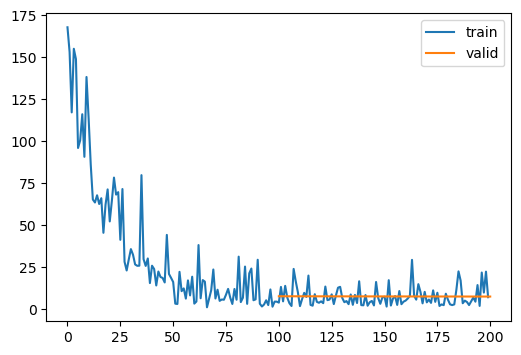

In [ ]:
learn = MomentumLearner(model, dls, F.mse_loss, lr=0.002, 
                        cbs=[DeviceCB(), metrics, ProgressCB(plot=True)]
                       )
learn.fit(2)

In [ ]:
weight_bias_list=[(name, param) for name, param in model.named_parameters()]; weight_bias_list

[('0.weight',
  Parameter containing:
  tensor([[-0.0050,  0.6095],
          [-0.3017,  0.4836],
          [-0.0730, -0.0200],
          [-0.2460, -0.6228],
          [ 0.0226, -0.0057],
          [ 0.0427,  0.5709],
          [ 0.0564,  1.0391],
          [ 0.1449, -1.0460],
          [ 0.0058, -0.9988],
          [-0.0725,  0.8961]], device='cuda:0', requires_grad=True)),
 ('0.bias',
  Parameter containing:
  tensor([ 0.6116,  0.5219,  0.6341, -0.5044, -0.1457,  0.5687,  0.0763,  1.7451,
           0.7130,  0.3970], device='cuda:0', requires_grad=True)),
 ('2.weight',
  Parameter containing:
  tensor([[ 0.9520,  0.8736,  0.8129,  0.2887, -0.1766,  0.7466,  0.8544,  2.2082,
            1.1304,  0.9044]], device='cuda:0', requires_grad=True)),
 ('2.bias',
  Parameter containing:
  tensor([2.9010], device='cuda:0', requires_grad=True))]

In [ ]:
weight_list = [#torch.Tensor.numpy(
    e[1].detach().cpu() for e in weight_bias_list if e[0].split('.')[1] == 'weight']
weight_list[0]

tensor([[-0.0050,  0.6095],
        [-0.3017,  0.4836],
        [-0.0730, -0.0200],
        [-0.2460, -0.6228],
        [ 0.0226, -0.0057],
        [ 0.0427,  0.5709],
        [ 0.0564,  1.0391],
        [ 0.1449, -1.0460],
        [ 0.0058, -0.9988],
        [-0.0725,  0.8961]])

In [ ]:
px.imshow(torch.Tensor.numpy(
    torch.concat(
        [e.histc(20,0,10)[None, :] for e in weight_list], 
        axis = 0)))

In [ ]:
np.histogram([1, 2, 1], bins=[0, 1, 2, 3])

(array([0, 2, 1]), array([0, 1, 2, 3]))

In [ ]:
np.histogram(weight_list[0], 
             bins=[0, 1, 10],
             density=True)

(array([0.9       , 0.01111111]), array([ 0,  1, 10]))

#

In [ ]:
# class apsimxDataset(Dataset):
#     def __init__(self, lookup_smc, ph, ys, soil, met, cult, device):
#         self.lookup_smc = lookup_smc
#         self.ph = ph
#         self.ys = ys
#         self.soil = soil
#         self.met = met
#         self.cult = cult
#         self.device = device
        
#     def __len__(self):
#         return self.ys.shape[0]
    
#     def __getitem__(self, idx):
#         s_i, m_i, c_i = self.lookup_smc[idx, ]
        
#         met_plant = torch.tensor(
#             [0.0 if ((i < int(self.ph[idx, 0])) or (i > int(self.ph[idx, 1]))) else 1.0
#             for i in range(365)])
#         if self.device == 'cuda':
#             met_plant = met_plant.to('cuda')
        
#         return self.ys[idx, ], self.soil[s_i, ], torch.concat([self.met[m_i, ], met_plant[:, None]], axis = 1), self.cult[c_i, ]

# device = 'cuda'

In [ ]:
class apsimxMet(Dataset):
    def __init__(self, met):
        self.met = met
    def __len__(self):
        return self.met.shape[0]
    def __getitem__(self, idx):
        return self.met[idx, ]

    

In [ ]:
# training_dataloader = DataLoader(apsimxMet(
#     met = torch.from_numpy(met_np).to(torch.float), #.to(device),
# ), 
#                                  batch_size = 25,
#                                  shuffle = True)

In [ ]:
data = DataLoaders(DataLoader(apsimxMet(
                met = torch.from_numpy(met_np[0:38, ]).to(torch.float), #.to(device),
            ), batch_size = 25, shuffle = True),
                   
            DataLoader(apsimxMet(
                met = torch.from_numpy(met_np[38:76, ]).to(torch.float), #.to(device),
            ), batch_size = 25, shuffle = True)
           )

In [ ]:
mod

In [ ]:
learn = Learner(data, Net(), loss_func=F.nll_loss, opt_func=Adam, metrics=accuracy)

In [ ]:
from torch import nn
mod = 

nn.Sequential(
    nn.Flatten(),
    nn.Linear(365*8, 1024),
    nn.ReLU(), 
    nn.Linear(1024, 365*8)
)


# mod(next(iter(training_dataloader)))

In [ ]:
# restrict to one location
met_np = met_np[0:38, ]

In [ ]:
import plotly.express as px
px.imshow(met_np[0].T[:, 0:30])

In [ ]:
cs = [met_np.mean(axis = 0), met_np.std(axis = 0)]
met_np = (met_np - cs[0])/cs[1]

In [ ]:
[e.shape for e in cs]

In [ ]:
px.imshow(next(iter(training_dataloader))[0].detach().cpu().T[:, 0:30])

In [ ]:
next(iter(training_dataloader)).shape

In [ ]:
from torch import nn
mod = nn.Sequential(
    nn.Flatten(),
    nn.Linear(365*8, 512),
    nn.ReLU(), 
    nn.Linear(512, 10),
    nn.ReLU(), 
    nn.Linear(10, 1)
)

mod(next(iter(training_dataloader)))

In [ ]:
class myLearn:
    def __init__(
        self, 
        model, 
        dl, # this is the basic dataloader
        loss_func,
        lr, 
        opt_func= torch.optim.SGD):
        self.model = model
        self.dl = dl
        self.loss_func = loss_func
        self.lr = lr
        self.opt_fun = opt_fun
    
    def one_batch():

In [ ]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

In [ ]:
# import torch
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader
# from torch import nn

# import torch.nn.functional as F # used in VAE



# lookup_smc = torch.from_numpy(np.array(res_lookup).astype(int))
# ph   = torch.from_numpy(np.array(res_plantharvest))
# ys   = torch.from_numpy(np.array(res_ys.loc[:, 'yield_Kgha']))
# soil = torch.from_numpy(np.array(soils_np_i)).swapaxes(1,2)
# met  = torch.from_numpy(np.array(met_np))
# cult = torch.from_numpy(np.array(cult_np))


# def cs_tensor(M):
#     mu_std = [M.mean(axis = 0), M.std(axis = 0)]
#     mu_std[1][mu_std[1] == 0] = 1
#     M_new = (M-mu_std[0])/mu_std[1]
#     return(mu_std, M_new)

# ys_cs,   ys   = cs_tensor(M = ys) 
# soil_cs, soil = cs_tensor(M = soil) 
# met_cs,  met  = cs_tensor(M = met) 
# cult_cs, cult = cs_tensor(M = cult) 





# training_dataloader = DataLoader(
#     apsimxDataset(
# #         lookup_smc = lookup_smc,
# #         ph = ph,
# #         ys = ys.to(torch.float),
# #         soil = soil.to(torch.float),
# #         met = met.to(torch.float),
# #         cult = cult.to(torch.float),
# #         device = 'cpu'
#         lookup_smc = lookup_smc.to(device),
#         ph = ph.to(device),
#         ys = ys.to(device).to(torch.float),
#         soil = soil.to(device).to(torch.float),
#         met = met.to(device).to(torch.float),
#         cult = cult.to(device).to(torch.float),
#         device = 'cuda'
#     ),
#     batch_size = 500,
#     shuffle = True
# )



# ys, soil, met, cult = next(iter(training_dataloader))
# [e.shape for e in [ys, soil, met, cult]]

# class invApsimxNet(nn.Module):
#     def __init__(self):
#         super(invApsimxNet, self).__init__()
# #         self.ynet = nn.Sequential(nn.Flatten())
#         self.snet = nn.Sequential(
#             nn.Conv1d(24, out_channels=36,
#                       kernel_size= 3, stride= 2, padding  = 1),
#             nn.BatchNorm1d(36),
#             nn.LeakyReLU(), 
#             nn.Conv1d(36, out_channels=64,
#                       kernel_size= 3, stride= 2, padding  = 1),
#             nn.BatchNorm1d(64),
#             nn.LeakyReLU(), 
#             nn.Conv1d(64, out_channels=128,
#                       kernel_size= 3, stride= 2, padding  = 1),
#             nn.BatchNorm1d(128),
#             nn.LeakyReLU(), 
#             nn.Conv1d(128, out_channels=256,
#                       kernel_size= 3, stride= 2, padding  = 1),
#             nn.BatchNorm1d(256),
#             nn.LeakyReLU(),  
#             nn.Conv1d(256, out_channels=512,
#                       kernel_size= 3, stride= 2, padding  = 1),
#             nn.BatchNorm1d(512),
#             nn.LeakyReLU(), 
#             nn.Flatten() # 3584 out
# )
#         self.mnet = nn.Sequential(
#             nn.LSTM(
#                 input_size = 9,
#                 hidden_size= 1, # hidden state features
#                 num_layers = 1, # number of lstms stacked
#                 bias = True,
#                 batch_first = True, 
#                 dropout = 0, # dropouts between layers
#                 bidirectional = False
#             )
#         )
#         self.mnet_f = nn.Flatten()
        
#         self.xnet = nn.Sequential(
#             nn.Linear(3950, 512),
#             nn.ReLU(),
#             nn.Linear(512, 64),
#             nn.ReLU(),
#             nn.Linear(64, 10)
#         )

#     def forward(self, ys, soil, met):
# #         y_out = self.ynet(ys)
#         y_out = ys
#         s_out = self.snet(soil)
#         m_out, _ = self.mnet(met)
#         m_out = self.mnet_f(m_out)
#         x_out = self.xnet(torch.concat([y_out[:, None], s_out, m_out], axis = 1))
#         return(x_out)
# # net = invApsimxNet()
# # net = invApsimxNet().to(device)
# # net(ys, soil, met).shape

# def train_loop(dataloader, model, loss_fn, optimizer, silent = False):
#     import torch
#     from torch.utils.data import Dataset
#     from torch.utils.data import DataLoader
#     size = len(dataloader.dataset)
#     for batch, (ys, soil, met, cult) in enumerate(dataloader):
#         # Compute prediction and loss
#         pred = model(ys, soil, met)
#         loss = loss_fn(pred, cult)

#         # Backpropagation
# #         torch.autograd.set_detect_anomaly(True)
#         optimizer.zero_grad()
# #         loss.backward(retain_graph=True)
#         loss.backward()
#         optimizer.step()

#         if batch % 100 == 0:
#             loss, current = loss.item(), batch * len(ys)
#             if not silent:
#                 print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# def train_error(dataloader, model, loss_fn, silent = False):
#     import torch
#     from torch.utils.data import Dataset
#     from torch.utils.data import DataLoader
    
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     train_loss = 0

#     with torch.no_grad():
#         for ys, soil, met, cult in dataloader:
#             pred = model(ys, soil, met)
#             train_loss += loss_fn(pred, cult).item() # <----------------------
            
#     train_loss /= num_batches
#     return(train_loss)


# def test_loop(dataloader, model, loss_fn, silent = False):
#     import torch
#     from torch.utils.data import Dataset
#     from torch.utils.data import DataLoader
    
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
#     test_loss = 0

#     with torch.no_grad():
#         for ys, soil, met, cult in dataloader:
#             pred = model(ys, soil, met)                
#             test_loss += loss_fn(pred, cult).item() # <-----------------------

#     test_loss /= num_batches
#     if not silent:
#         print(f"Test Error: Avg loss: {test_loss:>8f}")
#     return(test_loss)


# def train_nn(
#     cache_path,
#     training_dataloader,
#     testing_dataloader,
#     model,
#     learning_rate = 1e-3,
#     batch_size = 64,
#     epochs = 500,
#     model_prefix = 'model',
#     save_pt = False
# ):
#     import numpy as np
#     import pandas as pd
#     import torch
#     from torch import nn
#     from tqdm import tqdm
    
#     # Initialize the loss function
#     loss_fn = nn.MSELoss()

# #     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas= [0.98752, 0.972311])

#     loss_df = pd.DataFrame([i for i in range(epochs)], columns = ['Epoch'])
#     loss_df['TrainMSE'] = np.nan
#     loss_df['TestMSE']  = np.nan

#     for t in tqdm(range(epochs)):        
# #         print(f"Epoch {t+1}\n-------------------------------")
#         train_loop(training_dataloader, model, loss_fn, optimizer, silent = True)

#         loss_df.loc[loss_df.index == t, 'TrainMSE'
#                    ] = train_error(training_dataloader, model, loss_fn, silent = True)
        
#         loss_df.loc[loss_df.index == t, 'TestMSE'
#                    ] = test_loop(testing_dataloader, model, loss_fn, silent = True)
        
#         if (t+1)%5 == 0: # Cache in case training is interupted. 
#             # print(loss_df.loc[loss_df.index == t, ['TrainMSE', 'TestMSE']])
#             if save_pt:
#                 torch.save(model.state_dict(), 
#                            cache_path+'/'+model_prefix+'_'+str(t)+'_'+str(epochs)+'.pt') # convention is to use .pt or .pth
        
#     return([model, loss_df])


# def yhat_loop(dataloader, model):
#     import numpy as np
#     import pandas as pd
#     import torch
    
#     size = len(dataloader.dataset)
#     num_batches = len(dataloader)
    
#     y_true = np.array([])
#     y_pred = np.array([])
    
#     with torch.no_grad():
#         for ys, soil, met, cult in dataloader:
#             yhat_i = model(ys, soil, met)
#             y_pred = np.append(y_pred, np.array(yhat_i.cpu()))
#             y_true = np.append(y_true, np.array(cult.cpu()))
    
#     out = np.concatenate([y_true[:, None], y_pred[:, None]], axis = 1) 
#     out = pd.DataFrame(out, columns = ['y_true', 'y_pred'])
#     return(out)

# model = invApsimxNet().to(device)

# model, loss_df = train_nn(
#         cache_path,
#         training_dataloader,
#         training_dataloader,
#         model,
#         learning_rate = 1e-3,
#         batch_size = 500,
#         epochs = 1
#     )